In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

In [31]:
df = pd.read_csv('admit.csv')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GRE          400 non-null    int64  
 1   TOEFL        400 non-null    int64  
 2   Univ_Rating  400 non-null    int64  
 3   SOP          400 non-null    float64
 4   LOR          400 non-null    float64
 5   CGPA         400 non-null    float64
 6   Research     400 non-null    int64  
 7   Admit        400 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 25.1 KB


In [33]:
cols = list(map(lambda x:x.lower(), df.columns))

In [34]:
cols

['gre', 'toefl', 'univ_rating', 'sop', 'lor ', 'cgpa', 'research', 'admit']

In [35]:
cols = list(map(lambda x:x.rstrip(), df.columns))

In [36]:
cols

['GRE', 'TOEFL', 'Univ_Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Admit']

In [37]:
cols = list(map(lambda x:x.lower(), cols))

In [38]:
cols

['gre', 'toefl', 'univ_rating', 'sop', 'lor', 'cgpa', 'research', 'admit']

In [39]:
df.columns = cols

In [40]:
df['univ_rating'] = df['univ_rating'].astype('category')
df['research'] = df['research'].astype('category')

In [41]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test  = train_test_split(x,y, test_size=0.3,random_state=0)

In [43]:
dt = DecisionTreeClassifier()

In [44]:
dt.fit(x_train, y_train)

DecisionTreeClassifier()

In [45]:
from sklearn.tree import export_graphviz
import collections
import graphviz

In [46]:
estimator = dt

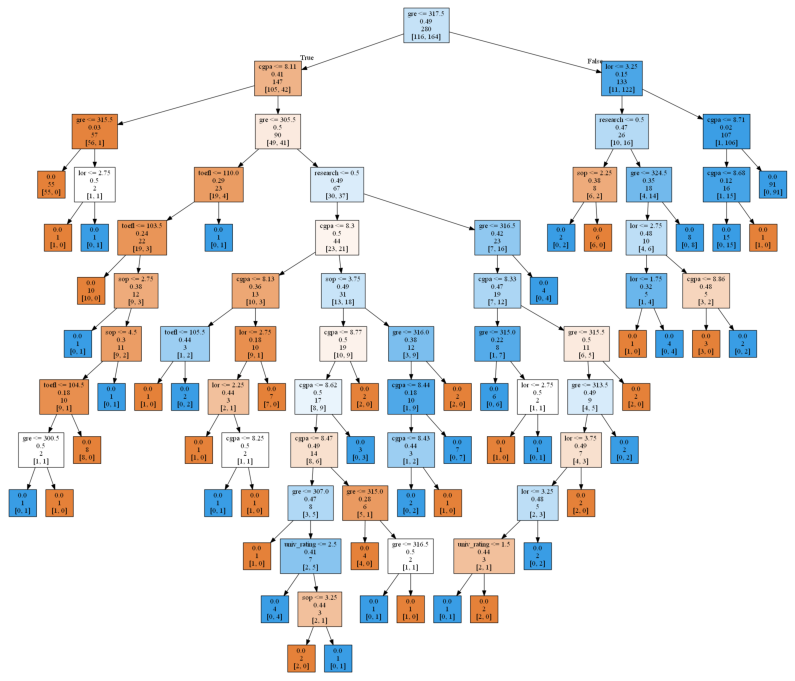

In [50]:
%matplotlib inline
export_graphviz(estimator, out_file='tree.dot',
               feature_names=x_train.columns, label=['No Admission', 'Admission'], precision=2, filled=True)
from subprocess import call
call(['dot','-Tpng','tree.dot','-o','tree.png','Gdpi=650'])
plt.figure(figsize=(14,18))
plt.imshow(plt.imread('tree.png'))
plt.axis('off')
plt.show()

In [48]:
import os
os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Library/bin/graphviz/'

In [52]:
pred_train = dt.predict(x_train)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, pred_train)
from sklearn.metrics import classification_report
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00       164

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



In [53]:
pred_test = dt.predict(x_test)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69        49
           1       0.79      0.79      0.79        71

    accuracy                           0.75       120
   macro avg       0.74      0.74      0.74       120
weighted avg       0.75      0.75      0.75       120



In [54]:
dt.feature_importances_

array([0.53667408, 0.03121762, 0.02102607, 0.06002414, 0.09704249,
       0.22070728, 0.0333083 ])

In [56]:
feature_importance = pd.DataFrame(data=dt.feature_importances_, columns=['Importance'])

In [57]:
feature_importance['features'] = x_train.columns

In [58]:
feature_importance


,Importance,features
0,0.536674,gre
1,0.031218,toefl
2,0.021026,univ_rating
3,0.060024,sop
4,0.097042,lor
5,0.220707,cgpa
6,0.033308,research


In [60]:
prune_classifier = DecisionTreeClassifier(random_state=0, ccp_alpha='auto')
path = prune_classifier.cost_complexity_pruning_path(x_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [62]:
impurities

array([0.        , 0.00642857, 0.01238095, 0.01863095, 0.02505952,
       0.0314881 , 0.03850564, 0.04558174, 0.06506226, 0.07714018,
       0.09053304, 0.09958513, 0.10434703, 0.11883638, 0.12393237,
       0.12922541, 0.15144764, 0.17825524, 0.18896952, 0.19998906,
       0.21749413, 0.23853503, 0.28635875, 0.48530612])

In [63]:
len(impurities)

24

In [66]:
clfs =[]
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

In [68]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

In [74]:
%matplotlib qt
fig, ax = plt.subplots()
ax.set_xlabel('Alpha Value')
ax.set_ylabel('Accuracy Score')
ax.set_title('Accuracy vs CCP Alpha')
ax.plot(ccp_alphas,train_scores, marker ='o', label = 'Train Data',
       drawstyle ='steps-post' )
ax.plot(ccp_alphas,test_scores, marker ='o', label = 'Test Data',
       drawstyle ='steps-post' )
ax.legend()
plt.show()

In [76]:
dt_pruned = DecisionTreeClassifier(ccp_alpha=0.0174, random_state=0)

In [77]:
dt_pruned.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0174, random_state=0)

In [78]:
pred_train = dt_pruned.predict(x_train)
pred_test = dt_pruned.predict(x_test)
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, pred_train)
test_accuracy = accuracy_score(y_test, pred_test)

In [79]:
print('Accuracy of Train data is :', train_accuracy)
print('Accuracy of Test data is :', test_accuracy)

Accuracy of Train data is : 0.8357142857142857
Accuracy of Test data is : 0.7833333333333333


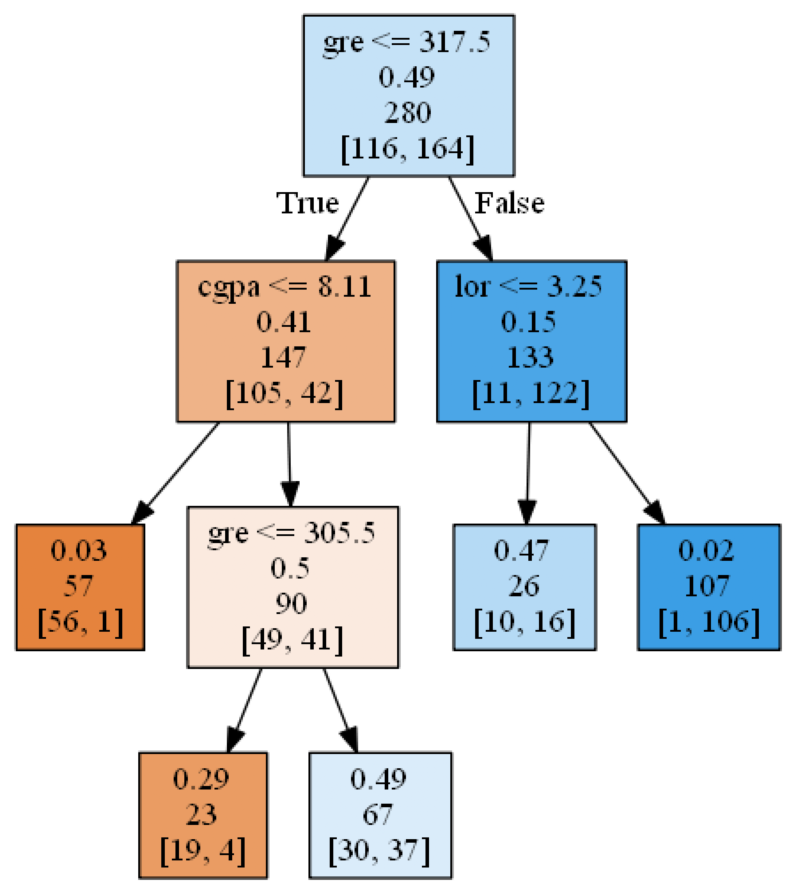

In [80]:
%matplotlib inline
export_graphviz(dt_pruned, out_file='tree.dot',
               feature_names=x_train.columns, label=['No Admission', 'Admission'], precision=2, filled=True)
from subprocess import call
call(['dot','-Tpng','tree.dot','-o','tree.png','Gdpi=650'])
plt.figure(figsize=(14,18))
plt.imshow(plt.imread('tree.png'))
plt.axis('off')
plt.show()

In [ ]:
CART
CHAID
C4.5